In [1]:
import tensorflow as tf
import numpy as np
import util
from timeit import default_timer as timer
from datetime import datetime
import pickle

In [2]:
XTrainTemp = util.readObject(path='pathXTrain')
YTrainTemp = util.readObject(path='pathYTrain')

XTestTemp = util.readObject(path='pathXTest')
YTestTemp = util.readObject(path='pathYTest')

XValidationTemp = util.readObject(path='pathXValidation')
YValidationTemp = util.readObject(path='pathYValidation')

In [3]:
xTrain, yTrain = util.consolidateInputsAndOutputs(XTrainTemp, YTrainTemp)
xTest, yTest = util.consolidateInputsAndOutputs(XTestTemp, YTestTemp)
xValidation, yValidation = util.consolidateInputsAndOutputs(XValidationTemp, YValidationTemp)

xTest = util.joinListParches(xTest, xValidation)
yTest = util.joinListParches(yTest, yValidation)
###all samples
xTrain = util.joinListParches(xTrain, xTest)
yTrain = util.joinListParches(yTrain, yTest)
xTrain = np.array(xTrain)
yTrain = np.array(yTrain)

xTest = np.array(xTest)
yTest = np.array(yTest)

xValidation = np.array(xValidation)
yValidation = np.array(yValidation)
# integer encode
yTrain = util.integerEncoded(yTrain)
yTest = util.integerEncoded(yTest)
yValidation = util.integerEncoded(yValidation)

In [4]:
print(np.shape(xTrain))
print(np.shape(yTrain))

print(np.shape(xTest))
print(np.shape(yTest))

print(np.shape(xValidation))
print(np.shape(yValidation))

(81612, 28, 28)
(81612,)
(31241, 28, 28)
(31241,)
(4188, 28, 28)
(4188,)


In [5]:
xTrain = xTrain.reshape((-1,28,28,1))
xTest = xTest.reshape((-1,28,28,1))
xValidation = xValidation.reshape((-1,28,28,1))
xTrain.shape, yTrain.shape

((81612, 28, 28, 1), (81612,))

In [40]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Conv2D, Flatten, MaxPool2D, Dropout, Input, BatchNormalization, GlobalAvgPool2D, Reshape,Multiply

def conv_layer(inp, f, k=3, s=1, bn=True, se=True, se_ratio=16) :
    out = Conv2D(f, k, strides=s, padding='same', kernel_initializer='he_uniform')(inp)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    
    if se:
        out_se = GlobalAvgPool2D()(out)
        r = f // se_ratio if (f // se_ratio) > 0 else 1
        out_se = Reshape((1, 1, f))(out_se) # Reshape((1, f))(out_se)
        out_se = Dense(r, kernel_initializer='he_uniform', activation='relu')(out_se)
        out_se = Dense(f, activation='sigmoid')(out_se)
        out = Multiply()([out, out_se])    
    return out

In [41]:
def model ():
    x   = Input(shape=(28,28,1))
    out = conv_layer(x, 32, se=True, se_ratio=16)
    out = MaxPool2D()(out)
    out = conv_layer(out, 32, se=True, se_ratio=16)
    out = MaxPool2D()(out)
    out = conv_layer(out, 32, se=True, se_ratio=16)
    out = MaxPool2D()(out)  
    out = Flatten()(out)
    out = Dense(128, kernel_initializer='he_uniform')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    #out = Dropout(0.5)(out)
    out = Dense(5, activation='softmax')(out)
    return Model(x, out)

In [42]:
with tf.device('/gpu:0'):
    model = model()


In [43]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
conv2d_7 (Conv2D)                (None, 28, 28, 32)    320         input_6[0][0]                    
____________________________________________________________________________________________________
batch_normalization_9 (BatchNorm (None, 28, 28, 32)    128         conv2d_7[0][0]                   
____________________________________________________________________________________________________
activation_9 (Activation)        (None, 28, 28, 32)    0           batch_normalization_9[0][0]      
___________________________________________________________________________________________

In [44]:
with tf.device('/gpu:0'):
    hist = model.fit(xTrain, yTrain, validation_split=0.1, epochs=20, batch_size=2048)

Train on 73450 samples, validate on 8162 samples
Epoch 1/20
73450/73450 [==============================] - 18s - loss: 0.4395 - acc: 0.8633 - val_loss: 1.3389 - val_acc: 0.4893
Epoch 2/20
73450/73450 [==============================] - 17s - loss: 0.1440 - acc: 0.9554 - val_loss: 1.4531 - val_acc: 0.4892
Epoch 3/20
73450/73450 [==============================] - 17s - loss: 0.1119 - acc: 0.9634 - val_loss: 1.3257 - val_acc: 0.4895
Epoch 4/20
73450/73450 [==============================] - 17s - loss: 0.0959 - acc: 0.9675 - val_loss: 0.9142 - val_acc: 0.6457
Epoch 5/20
73450/73450 [==============================] - 15s - loss: 0.0856 - acc: 0.9699 - val_loss: 0.5306 - val_acc: 0.8601
Epoch 6/20
73450/73450 [==============================] - 16s - loss: 0.0787 - acc: 0.9720 - val_loss: 0.3607 - val_acc: 0.9092
Epoch 7/20
73450/73450 [==============================] - 16s - loss: 0.0735 - acc: 0.9733 - val_loss: 0.3117 - val_acc: 0.9216
Epoch 8/20
73450/73450 [==============================]

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


df = pd.DataFrame(hist.history)
df.tail()

,acc,loss,val_acc,val_loss
15,0.984956,0.043188,0.952218,0.219365
16,0.985745,0.040688,0.952585,0.234063
17,0.987311,0.037691,0.955893,0.209071
18,0.988509,0.034790,0.952953,0.216815
19,0.989367,0.032714,0.956016,0.211274


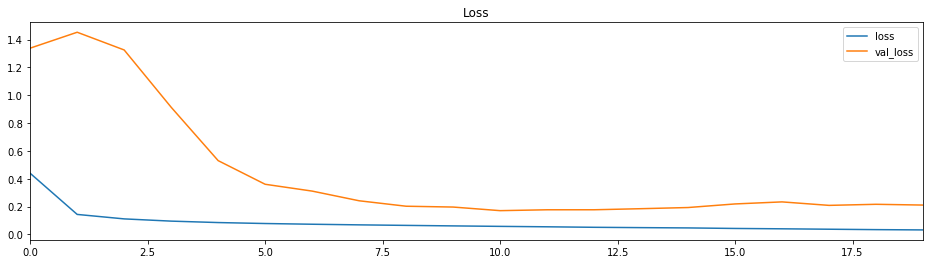

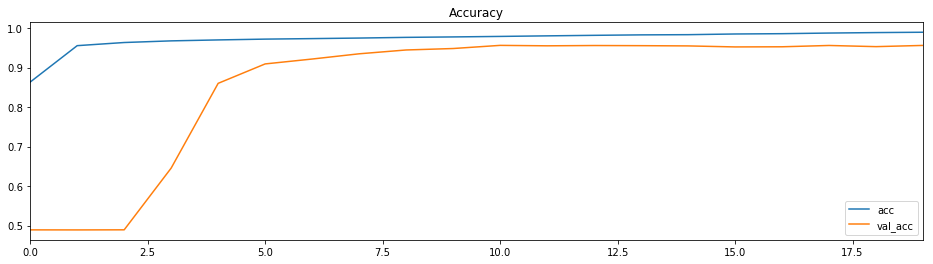

In [46]:
df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Loss')
df.plot(y=['acc', 'val_acc'], figsize=(16,4), title='Accuracy');

In [47]:
###saving model
##Saving weights and model
# serialize model to JSON
model_json = model.to_json()
with open("D:/fjam/Master Informatic PUCP/tesis/weightsAndModels/model1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("D:/fjam/Master Informatic PUCP/tesis/weightsAndModels/model1.h5py")
print("Saved model to disk")

Saved model to disk


In [48]:
folderPageImages = 'parzivalDataset'; 
folderGroundThruth = 'groundTruth'
ximg_test, xgt_test = util.readPageImagesAndGroundTruth(folderPageImages, folderGroundThruth, 'test', 2**-3)

In [49]:
ximg_test_superpixels       = util.readObject('pathSuperPixelesTest')

In [50]:
#i = np.random.choice(len(ximg_test))
i = 7
print(i)
superpixels = ximg_test_superpixels[i]
img = ximg_test[i]
XTestToPred, XCentralPointsTest, listSuperPixelesProcessedTest = util.doInputs([img], [superpixels], 28, 'test')
YTestToPred = util.doLabels([XCentralPointsTest[0]], [xgt_test[i]], folderGroundThruth, 'test', 2**3)
print(i)

7
7


In [51]:
print(i)
startTime = datetime.now()
visGT = np.zeros(img.shape[:3], dtype="uint8")
superpixels = listSuperPixelesProcessedTest[0]

for j in range(len(superpixels)) :
    if YTestToPred[0][j] == 'text' :    
        visGT[superpixels[j] == 255] = (0, 0, 255)
    elif YTestToPred[0][j] == 'decoration' :
        visGT[superpixels[j] == 255] = (255, 0, 0)
    elif YTestToPred[0][j] == 'comment' :
        visGT[superpixels[j] == 255] = (0, 255, 0)
    elif YTestToPred[0][j] == 'page' :
        visGT[superpixels[j] == 255] = (255, 255, 255)
    elif YTestToPred[0][j] == 'periphery' :
        visGT[superpixels[j] == 255] = (0, 0, 0)

7


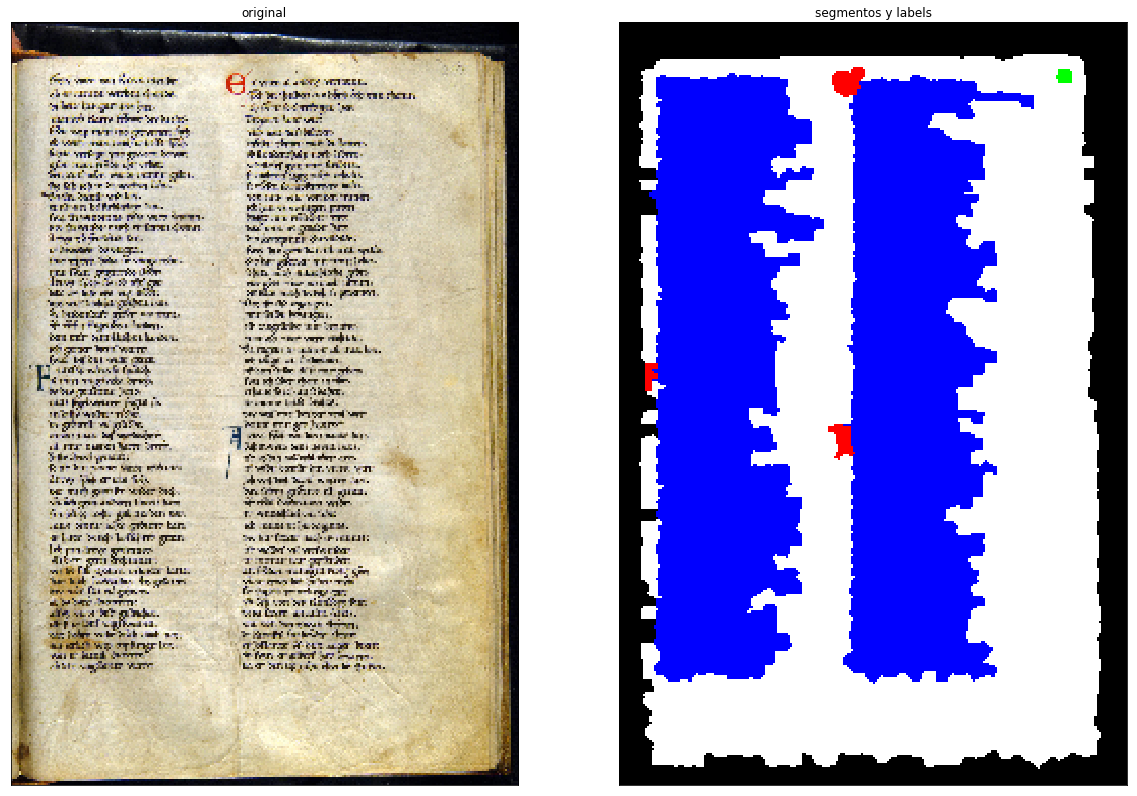

In [52]:
util.subplot(titles=['original','segmentos y labels'], images = [img, visGT], rows = 1, imgPerRows = 2, size = 20)


In [53]:
yPred = []
labels = []
for i in range(len(XTestToPred)) :
    labels = []
    for j in range(len(XTestToPred[i])) :
        predictedLabel = np.argmax(model.predict(XTestToPred[i][j].reshape(1,28,28,1), verbose=0)[0])
        labels.append(predictedLabel)
    yPred.append(labels)

In [54]:
np.shape(yPred)

(1, 2074)

In [55]:
print(yPred[0][0])

3


0:comment 1:decoration 2:page 3:periphery 4:text

In [56]:
print(i)
startTime = datetime.now()
visPred = np.zeros(img.shape[:3], dtype="uint8")

for k in range(len(superpixels)) :
    if yPred[0][k] == 4 :    
        visPred[superpixels[k] == 255] = (0, 0, 255)
    elif yPred[0][k] == 1 :
        visPred[superpixels[k] == 255] = (255, 0, 0)
    elif yPred[0][k] == 0 :
        visPred[superpixels[k] == 255] = (0, 255, 0)
    elif yPred[0][k] == 2 :
        visPred[superpixels[k] == 255] = (255, 255, 255)
    elif yPred[0][k] == 3 :
        visPred[superpixels[k] == 255] = (0, 0, 0)

0


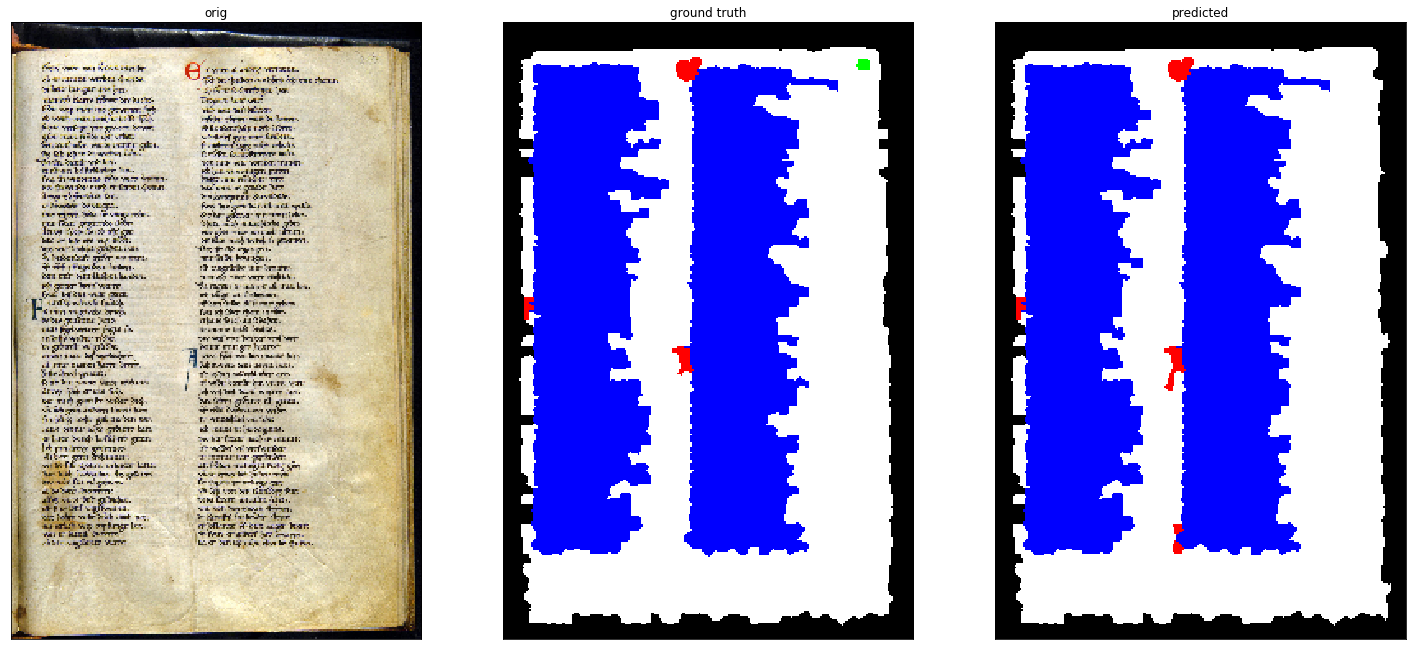

In [57]:
util.subplot(titles=['orig','ground truth', 'predicted'], imgPerRows=3, rows=1, size=25, images=[img, visGT, visPred])

In [24]:
def modelBasic ():
    x   = Input(shape=(28,28,1))
    out = conv_layer(x, 4)
    out = Flatten()(out)
    out = Dense(100, kernel_initializer='he_uniform')(out)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = Dropout(0.5)(out)
    out = Dense(5, activation='softmax',  kernel_initializer='he_uniform')(out)
    return Model(x, out)

In [25]:
with tf.device('/gpu:0'):
    model = modelBasic()
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 4)         40        
_________________________________________________________________
batch_normalization_5 (Batch (None, 28, 28, 4)         16        
_________________________________________________________________
activation_5 (Activation)    (None, 28, 28, 4)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 100)               313700    
_________________________________________________________________
batch_normalization_6 (Batch (None, 100)               400       
__________

In [26]:
with tf.device('/gpu:0'):
    hist = model.fit(xTrain, yTrain, validation_split=0.1, epochs=100, batch_size=2048)

Train on 73450 samples, validate on 8162 samples
Epoch 1/100
73450/73450 [==============================] - 16s - loss: 0.4893 - acc: 0.8516 - val_loss: 2.6886 - val_acc: 0.4978
Epoch 2/100
73450/73450 [==============================] - 13s - loss: 0.2297 - acc: 0.9335 - val_loss: 2.9882 - val_acc: 0.4996
Epoch 3/100
73450/73450 [==============================] - 13s - loss: 0.1753 - acc: 0.9463 - val_loss: 3.1860 - val_acc: 0.4974
Epoch 4/100
73450/73450 [==============================] - 13s - loss: 0.1440 - acc: 0.9543 - val_loss: 2.6897 - val_acc: 0.5032
Epoch 5/100
73450/73450 [==============================] - 13s - loss: 0.1235 - acc: 0.9608 - val_loss: 2.1728 - val_acc: 0.5164
Epoch 6/100
73450/73450 [==============================] - 13s - loss: 0.1106 - acc: 0.9638 - val_loss: 1.9120 - val_acc: 0.5403
Epoch 7/100
73450/73450 [==============================] - 13s - loss: 0.0995 - acc: 0.9667 - val_loss: 1.6649 - val_acc: 0.5722
Epoch 8/100
73450/73450 [=======================

73450/73450 [==============================] - 15s - loss: 0.0127 - acc: 0.9964 - val_loss: 0.3848 - val_acc: 0.9565
Epoch 64/100
73450/73450 [==============================] - 14s - loss: 0.0114 - acc: 0.9968 - val_loss: 0.3859 - val_acc: 0.9555
Epoch 65/100
73450/73450 [==============================] - 15s - loss: 0.0118 - acc: 0.9966 - val_loss: 0.3710 - val_acc: 0.9545
Epoch 66/100
73450/73450 [==============================] - 14s - loss: 0.0120 - acc: 0.9965 - val_loss: 0.3760 - val_acc: 0.9553
Epoch 67/100
73450/73450 [==============================] - 17s - loss: 0.0119 - acc: 0.9966 - val_loss: 0.3818 - val_acc: 0.9556
Epoch 68/100
73450/73450 [==============================] - 16s - loss: 0.0113 - acc: 0.9969 - val_loss: 0.3870 - val_acc: 0.9510
Epoch 69/100
73450/73450 [==============================] - 15s - loss: 0.0109 - acc: 0.9969 - val_loss: 0.4105 - val_acc: 0.9457
Epoch 70/100
73450/73450 [==============================] - 15s - loss: 0.0107 - acc: 0.9970 - val_loss

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.DataFrame(hist.history)
df.tail()

,acc,loss,val_acc,val_loss
95,0.997332,0.008467,0.956996,0.443283
96,0.997958,0.007231,0.955526,0.442085
97,0.997971,0.007067,0.953443,0.430524
98,0.997917,0.006972,0.955158,0.426490
99,0.997890,0.007210,0.949277,0.457324


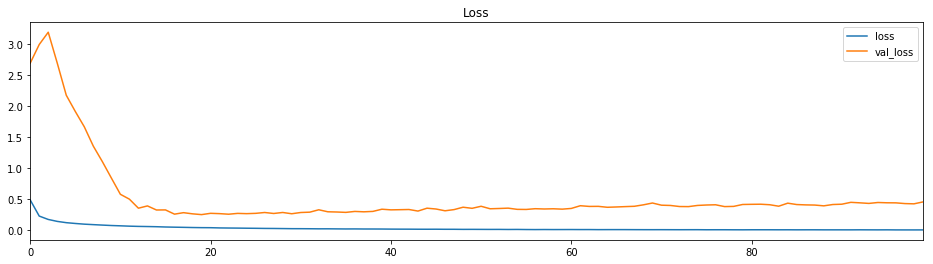

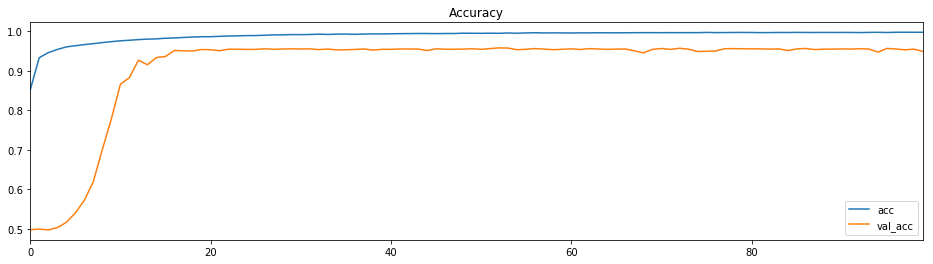

In [28]:
df.plot(y=['loss', 'val_loss'], figsize=(16,4), title='Loss')
df.plot(y=['acc', 'val_acc'], figsize=(16,4), title='Accuracy');

In [29]:
##Saving weights and model
# serialize model to JSON
model_json = model.to_json()
with open("D:/fjam/Master Informatic PUCP/tesis/weightsAndModels/model2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("D:/fjam/Master Informatic PUCP/tesis/weightsAndModels/model2.h5py")
print("Saved model to disk")

Saved model to disk


0


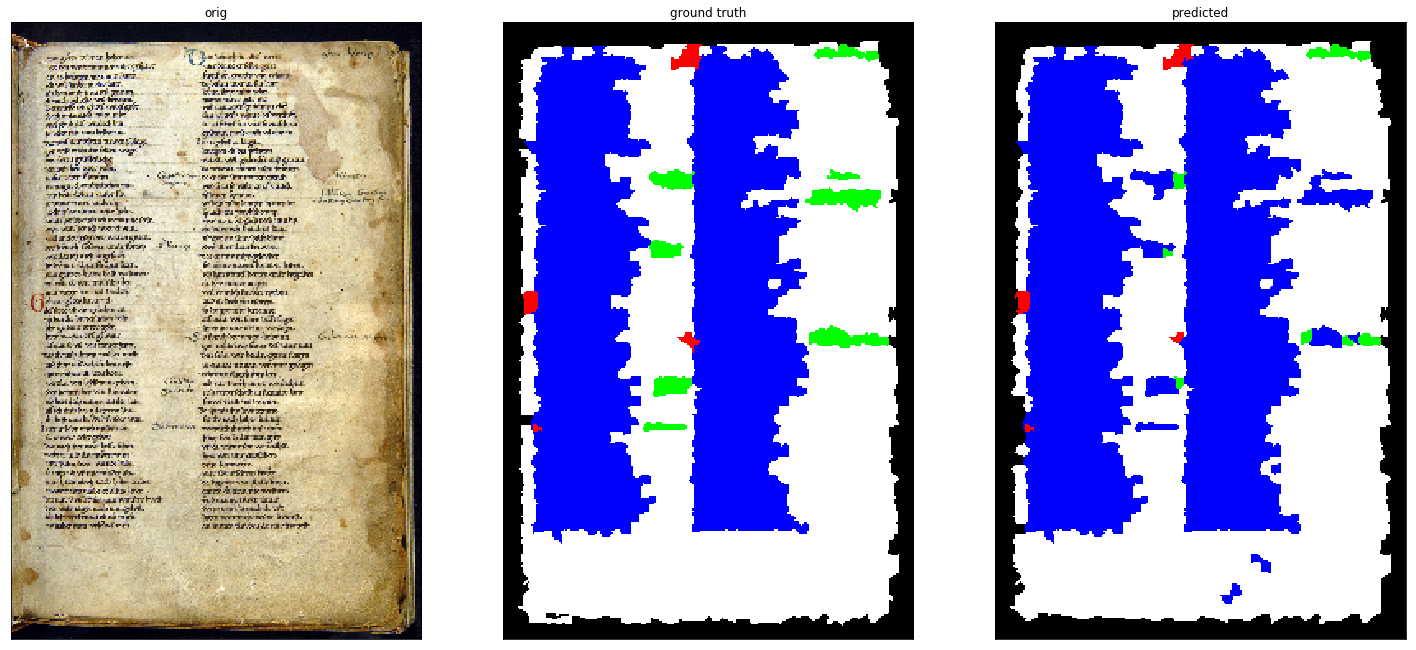

In [30]:
ximg_test_superpixels       = util.readObject('pathSuperPixelesTest')
superpixels = ximg_test_superpixels[i]
img = ximg_test[i]
XTestToPred, XCentralPointsTest, listSuperPixelesProcessedTest = util.doInputs([img], [superpixels], 28, 'test')
YTestToPred = util.doLabels([XCentralPointsTest[0]], [xgt_test[i]], folderGroundThruth, 'test', 2**3)
print(i)
startTime = datetime.now()
#isGT = np.zeros(img.shape[:2], dtype="float")
superpixels = listSuperPixelesProcessedTest[0]

yPred = []
labels = []
for i in range(len(XTestToPred)) :
    labels = []
    for j in range(len(XTestToPred[i])) :
        predictedLabel = np.argmax(model.predict(XTestToPred[i][j].reshape(1,28,28,1), verbose=0)[0])
        labels.append(predictedLabel)
    yPred.append(labels)    
    
startTime = datetime.now()
visPred = np.zeros(img.shape[:3], dtype="uint8")

for j in range(len(superpixels)) :
    if YTestToPred[0][j] == 'text' :    
        visGT[superpixels[j] == 255] = (0, 0, 255)
    elif YTestToPred[0][j] == 'decoration' :
        visGT[superpixels[j] == 255] = (255, 0, 0)
    elif YTestToPred[0][j] == 'comment' :
        visGT[superpixels[j] == 255] = (0, 255, 0)
    elif YTestToPred[0][j] == 'page' :
        visGT[superpixels[j] == 255] = (255, 255, 255)
    elif YTestToPred[0][j] == 'periphery' :
        visGT[superpixels[j] == 255] = (0, 0, 0)

for k in range(len(superpixels)) :
    if yPred[0][k] == 4 :    
        visPred[superpixels[k] == 255] = (0, 0, 255)
    elif yPred[0][k] == 1 :
        visPred[superpixels[k] == 255] = (255, 0, 0)
    elif yPred[0][k] == 0 :
        visPred[superpixels[k] == 255] = (0, 255, 0)
    elif yPred[0][k] == 2 :
        visPred[superpixels[k] == 255] = (255, 255, 255)
    elif yPred[0][k] == 3 :
        visPred[superpixels[k] == 255] = (0, 0, 0)
        
util.subplot(titles=['orig','ground truth', 'predicted'], imgPerRows=3, rows=1, size=25, images=[img, visGT, visPred])        